<a href="https://colab.research.google.com/github/ZahraShourmeij/Transformers/blob/master/bert_base_multilingual_uncased_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install accelerate -U

File ‘EXIST2021_training.tsv?rlkey=hjubyx1q7z8aizyx1hufnsi91’ already there; not retrieving.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   test_case  6977 non-null   object
 1   id         6977 non-null   int64 
 2   source     6977 non-null   object
 3   language   6977 non-null   object
 4   text       6977 non-null   object
 5   task1      6977 non-null   object
 6   task2      6977 non-null   object
dtypes: int64(1), object(6)
memory usage: 381.7+ KB


Generating train split: 0 examples [00:00, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/4883 [00:00<?, ? examples/s]

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.527093,0.751194,0.751194
2,0.537100,0.510866,0.756447,0.756447
3,0.537100,0.742871,0.756447,0.756447


Checkpoint destination directory training_dir/checkpoint-306 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory training_dir/checkpoint-612 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory training_dir/checkpoint-918 already exists and is non-empty. Saving will proceed but saved results may be invalid.


checkpoint-306	checkpoint-612	checkpoint-918	runs


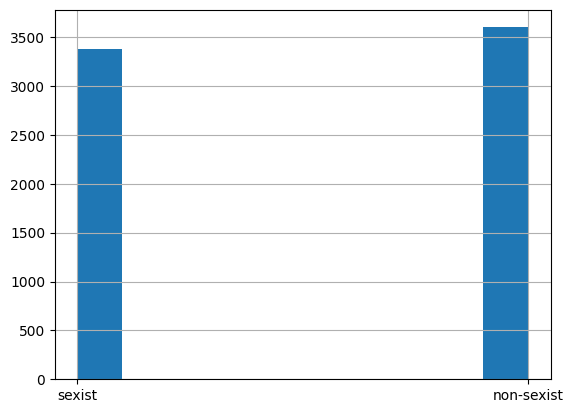

In [5]:
!wget -nc https://www.dropbox.com/scl/fi/354euga39eauii3ngp9u5/EXIST2021_training.tsv?rlkey=hjubyx1q7z8aizyx1hufnsi91&dl=0

!pip install transformers

import pandas as pd
import numpy as np

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

df = pd.read_csv('EXIST2021_training.tsv?rlkey=hjubyx1q7z8aizyx1hufnsi91', sep="\t")

df.info()

df = df[['task1','text']]

df.head()

df['task1'].hist()

target_map = { 'sexist': 1, 'non-sexist': 0}
df['target'] = df['task1'].map(target_map)

df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

!pip install datasets

from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files = 'data.csv')

raw_dataset

split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

split

# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = "nlptown/bert-base-multilingual-uncased-sentiment"
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

#The “truncation” argument is set to “True”, which means that the tokenization function will truncate sequences that are longer than the maximum length specified by the model.
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

tokenized_dataset = split.map(tokenize_fn, batched = True)

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, ignore_mismatched_sizes=True)


!pip install torchinfo

from torchinfo import summary
summary(model)

#!pip install accelerate -U

training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

trainer.train()

! ls training_dir

acc: 0.7564469914040115
f1: 0.7559123721896347


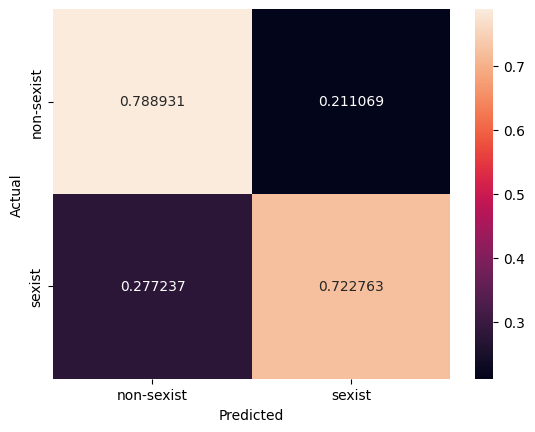

In [6]:
from transformers import pipeline

saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-612')

#pipeline("text-classification", model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

split['test']

prediction = saved_model(split['test']['sentence'])

prediction[:10]

def get_label(d):
    try:
        return int(d['label'].split('_')[1])
    except (KeyError, IndexError, ValueError):
        # Handle missing or invalid data
        return None

# Apply the function to each element in the prediction list
predictions = [get_label(d) for d in prediction]

print("acc:",accuracy_score(split['test']['label'], predictions))

print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['non-sexist','sexist']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)

